In [1]:
import tensorflow as tf
import shutil
import csv
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

/home/motoofi/miniconda2/envs/mlp/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [15]:
def make_kaggle_submission_file(predictions, modelName):
    ofile  = open('./results/Kaggle_submision_{0}.csv'.format(modelName), "wb")
    writer = csv.writer(ofile)
    writer.writerow(["Id","EpiOrStroma"])
    for i,score in enumerate(predictions):
        writer.writerow([i,score])

    ofile.close()

In [3]:
def make_input_Tensorflow(data,dataset):
    ofile  = open('tensoflow_{0}.data'.format(dataset), "wb")
    writer = csv.writer(ofile)
    #writer.writerow(data_x_train.columns)
    for tupple in data.itertuples():
        row = []
        for ele in tupple[1:]:
            row.append(ele)
        writer.writerow(row)

    ofile.close()

In [4]:
def build_model_columns():
    continues_columns = []
    for column in _CSV_COLUMNS[:-1]:
        continues_columns.append(tf.feature_column.numeric_column(column))
    return continues_columns

In [5]:
def build_estimator(model_dir,lr,l1,l2):
    """Build an estimator appropriate for the given model type."""
    columns = build_model_columns()
    
    return tf.estimator.LinearClassifier(
            model_dir=model_dir,
            feature_columns=columns,
            optimizer=tf.train.FtrlOptimizer(
            learning_rate=lr,
            l1_regularization_strength=l1,
            l2_regularization_strength=l2))

In [6]:
def input_fn(data_file, num_epochs, shuffle, batch_size):
    """Generate an input function for the Estimator."""
    assert tf.gfile.Exists(data_file), (
        '%s not found. Please make sure you have either run data_download.py or '
        'set both arguments --train_data and --test_data.' % data_file)

    def parse_csv(value):
        print('Parsing', data_file)
        columns = tf.decode_csv(value, record_defaults=_CSV_COLUMN_DEFAULTS)
        features = dict(zip(_CSV_COLUMNS, columns))
        labels = features.pop('label')
        return features, tf.equal(labels, 2)

    # Extract lines from input files using the Dataset API.
    dataset = tf.data.TextLineDataset(data_file)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=_NUM_EXAMPLES['train'])

    dataset = dataset.map(parse_csv, num_parallel_calls=5)

    # We call repeat after shuffling, rather than before, to prevent separate
    # epochs from blending together.
    dataset = dataset.repeat(num_epochs)
    dataset = dataset.batch(batch_size)
    return dataset

In [7]:
data_x_train = pd.read_csv("./X_train.csv")
X_test = pd.read_csv("./X_test.csv")
data_y_train = pd.read_csv("./y_train.csv")

_CSV_COLUMN_DEFAULTS = [[0.0] for _ in range(len(data_x_train.columns))]
_CSV_COLUMN_DEFAULTS.append([1.])
_CSV_COLUMNS = [str(col) for col in data_x_train.columns]
_CSV_COLUMNS.append('label')

X_train, X_val, Y_train, Y_val = train_test_split(data_x_train, data_y_train, test_size = 0.2, random_state = 0)

XY_train = pd.concat([X_train,Y_train['EpiOrStroma']], axis=1) 
XY_val = pd.concat([X_val,Y_val['EpiOrStroma']], axis=1) 
X_test['label'] = 0. 


sc_X = StandardScaler()
XY_train_scaled = pd.DataFrame(sc_X.fit_transform(XY_train), columns = _CSV_COLUMNS)
XY_train_scaled.loc[XY_train_scaled['label']>0,'label'] = 2
XY_train_scaled.loc[XY_train_scaled['label']<0,'label'] = 1

X_test_scaled = pd.DataFrame(sc_X.transform(X_test), columns = _CSV_COLUMNS)
#del X_test_scaled['label']


XY_val_scaled = pd.DataFrame(sc_X.transform(XY_val), columns = _CSV_COLUMNS)
XY_val_scaled.loc[XY_val_scaled['label']>0,'label'] = 2
XY_val_scaled.loc[XY_val_scaled['label']<0,'label'] = 1

_NUM_EXAMPLES = {'train': len(XY_train_scaled), 'validation': len(XY_val_scaled)}

In [8]:
make_input_Tensorflow(XY_train_scaled,"training")
make_input_Tensorflow(XY_val_scaled,"validation")
make_input_Tensorflow(X_test_scaled,"test")

In [9]:
model_dir = "./model/"
train_data  = "./tensoflow_training.data"
val_data = "./tensoflow_validation.data"
test_data = "./tensoflow_test.data"
train_epochs = 200
epochs_per_eval = 10
batch_size = 60
lr=0.001
l1=0.001
l2=0.01
accuracies = []
errors = []
shutil.rmtree(model_dir, ignore_errors=True)
model = build_estimator(model_dir,lr,l1)

# Train and evaluate the model every `FLAGS.epochs_per_eval` epochs.
for n in range(train_epochs // epochs_per_eval):
    model.train(input_fn=lambda: input_fn(train_data, epochs_per_eval, True, batch_size))

    results = model.evaluate(input_fn=lambda: input_fn(val_data, 1, False, batch_size))

    # Display evaluation metrics
    print('Results at epoch', (n + 1) * epochs_per_eval)
    print('-' * 60)

    for key in sorted(results):
        if key=="accuracy":
            accuracies.append(results[key])
        if key=="average_loss":
            errors.append(results[key])
        print('%s: %s' % (key, results[key]))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f261c72f350>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': './model/', '_save_summary_steps': 100}
('Parsing', './tensoflow_training.data')
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./model/model.ckpt.
INFO:tensorflow:loss = 41.588837, step = 1
INFO:tensorflow:Saving checkpoints for 80 into ./model/model.ckpt.
INFO:tensorflow:Loss for final step: 28.985535.
('Parsing', './tensoflow_validation.data')
INFO:tensorflow:Starting evaluation at 2018-02-19-19:39:01
INFO:tensorflow:Re

('Results at epoch', 70)
------------------------------------------------------------
accuracy: 0.84166664
accuracy_baseline: 0.64166665
auc: 0.89247966
auc_precision_recall: 0.87885386
average_loss: 0.446197
global_step: 560
label/mean: 0.64166665
loss: 26.77182
prediction/mean: 0.5175468
('Parsing', './tensoflow_training.data')
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-560
INFO:tensorflow:Saving checkpoints for 561 into ./model/model.ckpt.
INFO:tensorflow:loss = 24.413347, step = 561
INFO:tensorflow:Saving checkpoints for 640 into ./model/model.ckpt.
INFO:tensorflow:Loss for final step: 24.715786.
('Parsing', './tensoflow_validation.data')
INFO:tensorflow:Starting evaluation at 2018-02-19-19:40:47
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-640
INFO:tensorflow:Finished evaluation at 2018-02-19-19:40:49
INFO:tensorflow:Saving dict for global step 640: accuracy = 0.84166664, accuracy_baseline = 0.64166665, 

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-1120
INFO:tensorflow:Saving checkpoints for 1121 into ./model/model.ckpt.
INFO:tensorflow:loss = 17.233593, step = 1121
INFO:tensorflow:Saving checkpoints for 1200 into ./model/model.ckpt.
INFO:tensorflow:Loss for final step: 27.109982.
('Parsing', './tensoflow_validation.data')
INFO:tensorflow:Starting evaluation at 2018-02-19-19:42:43
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-1200
INFO:tensorflow:Finished evaluation at 2018-02-19-19:42:45
INFO:tensorflow:Saving dict for global step 1200: accuracy = 0.85, accuracy_baseline = 0.64166665, auc = 0.89821804, auc_precision_recall = 0.8960038, average_loss = 0.41346875, global_step = 1200, label/mean = 0.64166665, loss = 24.808125, prediction/mean = 0.5275988
('Results at epoch', 150)
------------------------------------------------------------
accuracy: 0.85
accuracy_baseline: 0.64166665
auc: 0.89821804
auc_precision_

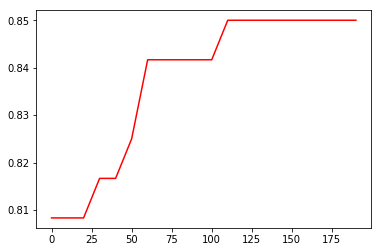

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([x for x in range(0,200,10)], accuracies, 'r')
plt.show()

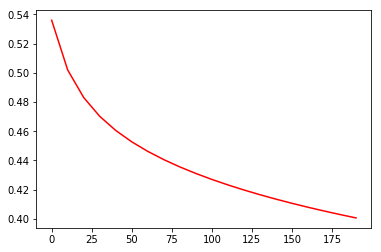

In [12]:
plt.plot([x for x in range(0,200,10)], errors, 'r')
plt.show()

In [17]:
test_data = "./tensoflow_test.data"
pred = model.predict(input_fn=lambda: input_fn(test_data, 1, False, 1))
make_kaggle_submission_file([int(x['classes'][0])+1 for x in pred],"tensorflow_LR_{0}epochs_{1}lr_{2}l1_{3}l2".format(train_epochs,lr,l1,l2))

('Parsing', './tensoflow_test.data')
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-1600
